# AML NLP project

## Import libraries

In [95]:
import pandas as pd
import seaborn as sns
import numpy as np
import nltk
nltk.download('punkt_tab')
from nltk import tokenize
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model, metrics


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\SAM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Read data

Data can be found here : https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset/data

In [2]:
text_data = pd.read_csv("../data/train_v2_drcat_02.csv")

In [3]:
text_data.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [4]:
text_data.nunique()

text             44868
label                2
prompt_name         15
source              17
RDizzl3_seven        2
dtype: int64

Let's keep the original prompts

In [5]:
seven_text_data = text_data[text_data['RDizzl3_seven'] == True]

In [6]:
seven_text_data.nunique()

text             20450
label                2
prompt_name          7
source              17
RDizzl3_seven        1
dtype: int64

Here we can see that we have 7 different prompts left.

In [7]:
seven_text_data['prompt_name'].unique()

array(['Car-free cities', '"A Cowboy Who Rode the Waves"',
       'Exploring Venus', 'Facial action coding system',
       'The Face on Mars', 'Driverless cars',
       'Does the electoral college work?'], dtype=object)

In [8]:
# Remove the " " " in the prompt names
seven_text_data['prompt_name'] = seven_text_data['prompt_name'].str.replace('''"''','')
seven_text_data['prompt_name'].unique()

C:\Users\SAM\AppData\Local\Temp\ipykernel_8548\2785384403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seven_text_data['prompt_name'] = seven_text_data['prompt_name'].str.replace('''"''','')


array(['Car-free cities', 'A Cowboy Who Rode the Waves',
       'Exploring Venus', 'Facial action coding system',
       'The Face on Mars', 'Driverless cars',
       'Does the electoral college work?'], dtype=object)

In [9]:
seven_text_data['source'].unique()

array(['persuade_corpus', 'mistral7binstruct_v2', 'darragh_claude_v6',
       'llama_70b_v1', 'llama2_chat', 'darragh_claude_v7',
       'falcon_180b_v1', 'chat_gpt_moth', 'radek_500',
       'mistral7binstruct_v1', 'NousResearch/Llama-2-7b-chat-hf',
       'mistralai/Mistral-7B-Instruct-v0.1', 'palm-text-bison1',
       'cohere-command', 'radekgpt4', 'train_essays', 'kingki19_palm'],
      dtype=object)

## Data mining and Feature engineering

### Visualization

Class imbalance

In [10]:
seven_text_data.groupby('label').count()

,text,prompt_name,source,RDizzl3_seven
label,,,,
0,14250,14250,14250,14250
1,6200,6200,6200,6200


<Axes: xlabel='label', ylabel='text'>

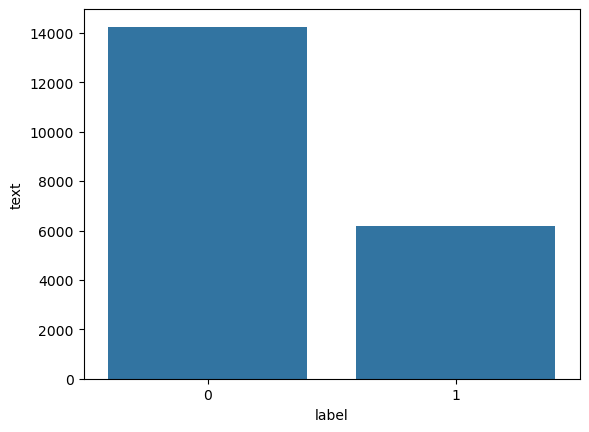

In [11]:
sns.barplot(seven_text_data.groupby('label').count(), x = 'label', y = 'text')

We notice a huge class imbalance : there are more handwritten text than AI generated

Add essay length column

In [12]:
seven_text_data['length'] = seven_text_data['text'].str.len()
seven_text_data.head()

C:\Users\SAM\AppData\Local\Temp\ipykernel_8548\634078843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seven_text_data['length'] = seven_text_data['text'].str.len()


,text,label,prompt_name,source,RDizzl3_seven,length
1168,Cars have been around for awhile and they have...,0,Car-free cities,persuade_corpus,True,3114
1169,Have you ever thought what it would be like no...,0,Car-free cities,persuade_corpus,True,1132
1170,What you are about to read is going to give yo...,0,Car-free cities,persuade_corpus,True,3319
1171,cars have many flaws nd and in this day and ag...,0,Car-free cities,persuade_corpus,True,1030
1172,There are many advantages of limiting car usag...,0,Car-free cities,persuade_corpus,True,1860


<Axes: xlabel='length', ylabel='Count'>

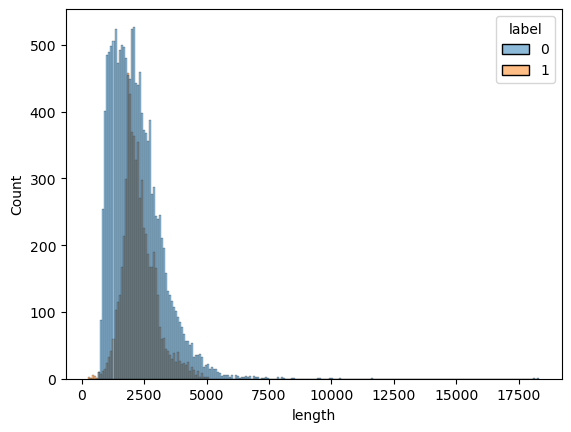

In [13]:
sns.histplot(seven_text_data, x = 'length', hue = 'label')

In [14]:
mapping = dict(zip(seven_text_data['prompt_name'].unique(), range(7)))
seven_text_data['prompt_id'] = seven_text_data.replace(mapping)['prompt_name']


C:\Users\SAM\AppData\Local\Temp\ipykernel_8548\1491141852.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  seven_text_data['prompt_id'] = seven_text_data.replace(mapping)['prompt_name']
C:\Users\SAM\AppData\Local\Temp\ipykernel_8548\1491141852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seven_text_data['prompt_id'] = seven_text_data.replace(mapping)['prompt_name']


<Axes: xlabel='prompt_id', ylabel='text'>

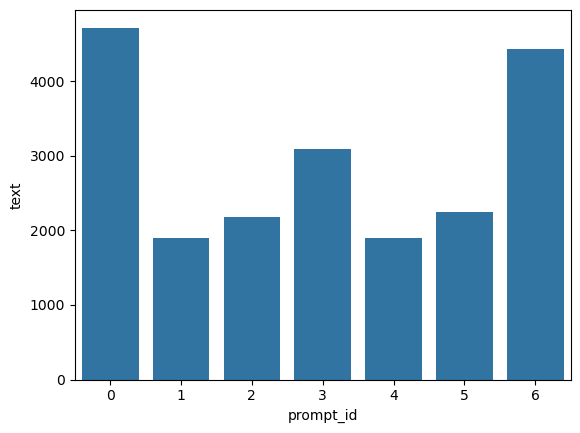

In [15]:
sns.barplot(seven_text_data.groupby('prompt_id').count(),x = 'prompt_id', y = 'text')

C:\Users\SAM\AppData\Local\Temp\ipykernel_8548\3811277724.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  seven_text_data['source_id'] = seven_text_data.replace(mapping_source)['source']
C:\Users\SAM\AppData\Local\Temp\ipykernel_8548\3811277724.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seven_text_data['source_id'] = seven_text_data.replace(mapping_source)['source']


Text(0.5, 1.0, 'Number of essays by source')

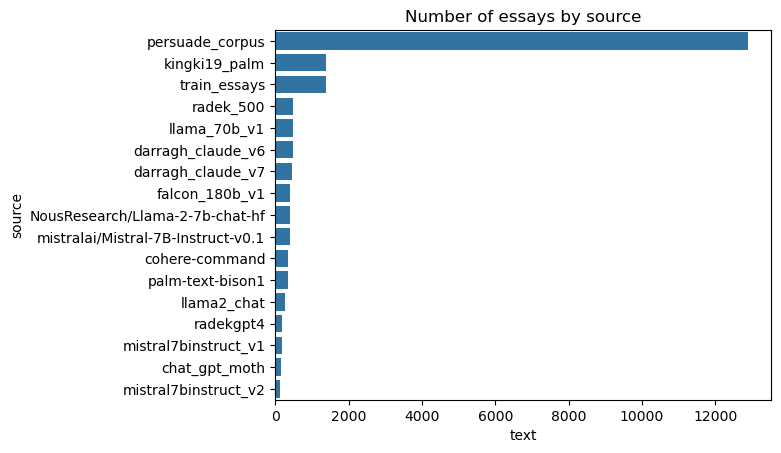

In [16]:
mapping_source = dict(zip(seven_text_data['source'].unique(), range(len(seven_text_data['source'].unique()))))
seven_text_data['source_id'] = seven_text_data.replace(mapping_source)['source']
sorted_seven_text_data = seven_text_data.groupby('source').count().sort_values("text", ascending=False)
sns.barplot(sorted_seven_text_data,x = 'text', y = 'source', orient = 'h')
plt.title("Number of essays by source")

The sources are highly skewed so me might need to balance this later

In [17]:
def word_count(text):
    text_list = text.split()
    return len(text_list)


In [18]:
seven_text_data['word_count'] = seven_text_data['text'].apply(word_count)
seven_text_data.head()

C:\Users\SAM\AppData\Local\Temp\ipykernel_8548\1209599868.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seven_text_data['word_count'] = seven_text_data['text'].apply(word_count)


,text,label,prompt_name,source,RDizzl3_seven,length,prompt_id,source_id,word_count
1168,Cars have been around for awhile and they have...,0,Car-free cities,persuade_corpus,True,3114,0,0,537
1169,Have you ever thought what it would be like no...,0,Car-free cities,persuade_corpus,True,1132,0,0,212
1170,What you are about to read is going to give yo...,0,Car-free cities,persuade_corpus,True,3319,0,0,620
1171,cars have many flaws nd and in this day and ag...,0,Car-free cities,persuade_corpus,True,1030,0,0,190
1172,There are many advantages of limiting car usag...,0,Car-free cities,persuade_corpus,True,1860,0,0,314


<Axes: xlabel='word_count', ylabel='Count'>

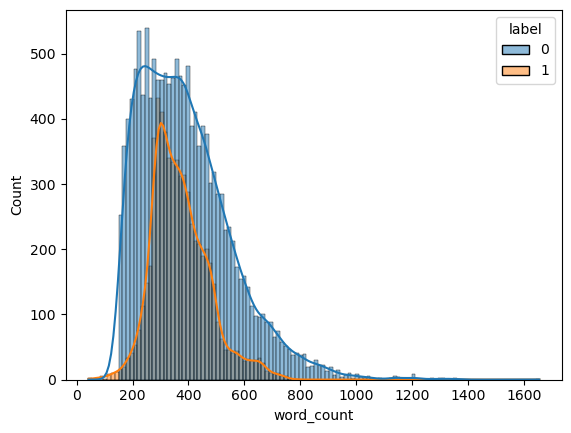

In [19]:
sns.histplot(seven_text_data, x = 'word_count',kde=True, hue='label')

In [20]:
seven_text_data['mean_word_length'] = seven_text_data['text'].apply(
    lambda x: np.mean([len(word) for word in x.split()])
)

C:\Users\SAM\AppData\Local\Temp\ipykernel_8548\2075753603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seven_text_data['mean_word_length'] = seven_text_data['text'].apply(


<Axes: xlabel='mean_word_length', ylabel='Count'>

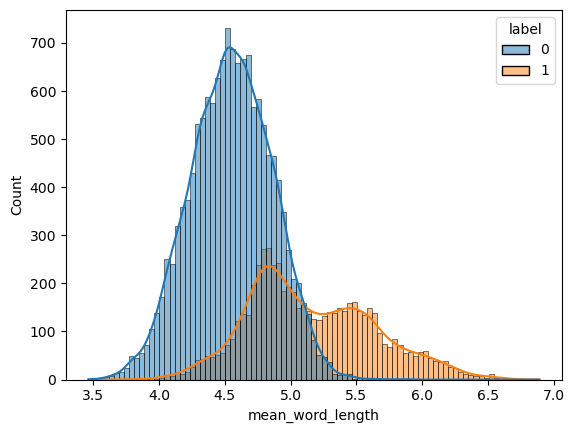

In [21]:
sns.histplot(seven_text_data, x = 'mean_word_length',kde=True, hue='label')

In [22]:
seven_text_data['mean_sent_length'] = seven_text_data['text'].apply(
    lambda x: np.mean([len(sent) for sent in tokenize.sent_tokenize(x)])
)


C:\Users\SAM\AppData\Local\Temp\ipykernel_8548\4082350521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seven_text_data['mean_sent_length'] = seven_text_data['text'].apply(


<Axes: xlabel='mean_sent_length', ylabel='Count'>

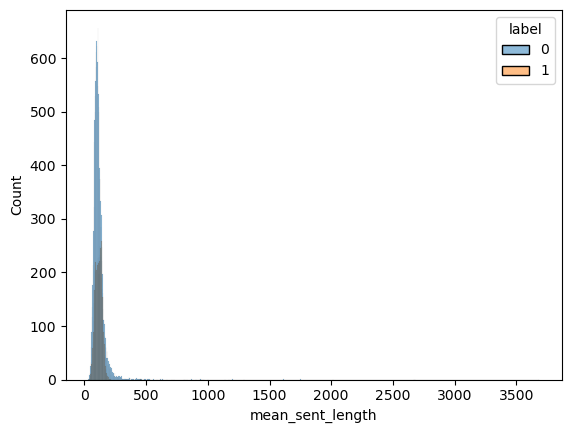

In [23]:
sns.histplot(seven_text_data, x = 'mean_sent_length', hue='label')

### TF-IDF

Example of an essay

In [41]:
random_idx = np.random.randint(seven_text_data.shape[0])
seven_text_data.iloc[random_idx]['text']

'In the course of human existance, humanity has always been striving for progress, you might say going the extra mile, in order to better our society. One such great invention was the automobile which allowed us to travel great distances in a short period of time. Consequently, the natural instinct, to grow and improve, has been transfered to the idea of the automobile through the self driving car. Self driving cars are the future of transportation as the offer a host of positive benefits including, precise driving capabilities, increasing affordability, and new safety technology.\n\nThe self driving car has begun implementing technology that can revolutionize a car\'s self awarness. For example the article states, "spinning sensor on the roof. Dubbed LIDAR, it uses laser beams to form a constantly updating 3D model of the car\'s surroundings." Unlike the human eye, the LIDAR radar sees anything and everything; not only does it never miss a single detail, but it also has a 360 degree v

After going through the corpus we see \n to jump lines and  \ before ' that we have to manage for text processing.

In [134]:
corpus = seven_text_data['text']
vectorizer = TfidfVectorizer(max_features = 10000,
                            stop_words = 'english',
                            )
X = vectorizer.fit_transform(corpus,
                            )

In [135]:
features = vectorizer.get_feature_names_out()

In [136]:
print("vectorized corpus dimensions : ", X.shape)
print("corpus dataset dimensions : ", seven_text_data.shape)

vectorized corpus dimensions :  (20450, 10000)
corpus dataset dimensions :  (20450, 11)


Each line of X represents an essay in the corpus, and each column represents a word

## Machine learning task

In [137]:
y = seven_text_data['label'].values
y.shape

(20450,)

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [139]:
reg = linear_model.LogisticRegression()

In [140]:
reg.fit(X_train,y_train)

LogisticRegression()

In [141]:
y_pred = reg.predict(X_test)

In [144]:
metrics.f1_score(y_test,y_pred)

0.986737400530504